In [53]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, concatenate, Embedding, LSTM, Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

from keras.utils import np_utils, plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [32]:
# 定数
# msm
lats = ["35.10", "35.15", "35.20", "35.25", "35.30", "35.35", "35.40", "35.45", "35.50"]
lons = ["139.1250", "139.1875", "139.2500", "139.3125", "139.3750", "139.4375", "139.5000", "139.5625", "139.6250"]
data_names = ["UGRD", "VGRD", "TMP", "RH", "PRMSL", "PRES", "APCP"]

# 平塚観測塔
hiratsuka_data_path = "../data/hiratsuka/avg_1h"

# 気象庁
kishocho_data_path = "../data/kishocho"
locations = ["hiratsuka", "odawara", "tsujido"]
skiprow_counts = [5, 6, 6] # csvのheader行数
colmns = [[0,1], [0,1,4,7,10,12], [0,1,4,7,10,12]]
colmn_names = [["time", "rain"], ["time", "tmp", "rain", "sun", "wind_vel", "wind_dir"], ["time", "tmp", "rain", "sun", "wind_vel", "wind_dir"]]
wind_dir = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW", "Q"]

step = 10
msm_first = -3
predict_hour = 1

# utils

In [6]:
def searchColumn(word, cols):
    return [col for col in cols if word in col]

In [30]:
def removeColumn(col, cols):
    return [x for x in cols if x != col]

In [45]:
def plot_wind(data_array, column_array, label_array, start=None, end=None):
    
    fig = plt.figure(figsize=(18, 12), dpi=80)
    ax1 = fig.add_subplot(2,1,1)
    
    if start is not None and end is not None:
        data_array_ = []
        for data in data_array:
            data_ = data.query('time >= \"{0}\" & time < \"{1}\"'.format(start, end))
            data_array_.append(data_)
        data_array = data_array_
    
    for (data, column, label) in zip(data_array, column_array, label_array) :
        ax1.plot(data["time"], data[column], label = label)

    plt.legend()
    plt.show()

# format

In [7]:
data = pd.read_csv("rowdata.csv")

In [56]:
data["time"] = pd.to_datetime(data["time"])
start_2017 = datetime(2017,7,1,0,0,0)
train_data = data.query('time < \"{0}\" '.format(start_2017))
test_data = data.query('time >= \"{0}\" '.format(start_2017))

In [57]:
train_hiratsuka = train_data[searchColumn("measured", data.columns)]
train_msm = train_data[searchColumn("msm", data.columns)]
train_kishocho = train_data[searchColumn("kishocho", data.columns)]
train_label = train_data[searchColumn("label", data.columns)]

test_hiratsuka = test_data[searchColumn("measured", data.columns)]
test_msm = test_data[searchColumn("msm", data.columns)]
test_kishocho = test_data[searchColumn("kishocho", data.columns)]
test_label = test_data[searchColumn("label", data.columns)]

train_rnn_hiratsuka = np.array(train_hiratsuka)
train_rnn_hiratsuka = train_rnn_hiratsuka.reshape(train_rnn_hiratsuka.shape[0], step, int(train_rnn_hiratsuka.shape[1]/step))
train_rnn_hiratsuka = train_rnn_hiratsuka[:, ::-1, :]
train_rnn_msm = np.array(train_msm)
train_rnn_msm = train_rnn_msm.reshape(train_rnn_msm.shape[0], step, int(train_rnn_msm.shape[1]/step))
train_rnn_msm = train_rnn_msm[:, ::-1, :]
train_rnn_kishocho = np.array(train_kishocho)
train_rnn_kishocho = train_rnn_kishocho.reshape(train_rnn_kishocho.shape[0], step, int(train_rnn_kishocho.shape[1]/step))
train_rnn_kishocho = train_rnn_kishocho[:, ::-1, :]

test_rnn_hiratsuka = np.array(test_hiratsuka)
test_rnn_hiratsuka = test_rnn_hiratsuka.reshape(test_rnn_hiratsuka.shape[0], step, int(test_rnn_hiratsuka.shape[1]/step))
test_rnn_hiratsuka = test_rnn_hiratsuka[:, ::-1, :]
test_rnn_msm = np.array(test_msm)
test_rnn_msm = test_rnn_msm.reshape(test_rnn_msm.shape[0], step, int(test_rnn_msm.shape[1]/step))
test_rnn_msm = test_rnn_msm[:, ::-1, :]
test_rnn_kishocho = np.array(test_kishocho)
test_rnn_kishocho = test_rnn_kishocho.reshape(test_rnn_kishocho.shape[0], step, int(test_rnn_kishocho.shape[1]/step))
test_rnn_kishocho = test_rnn_kishocho[:, ::-1, :]

# training

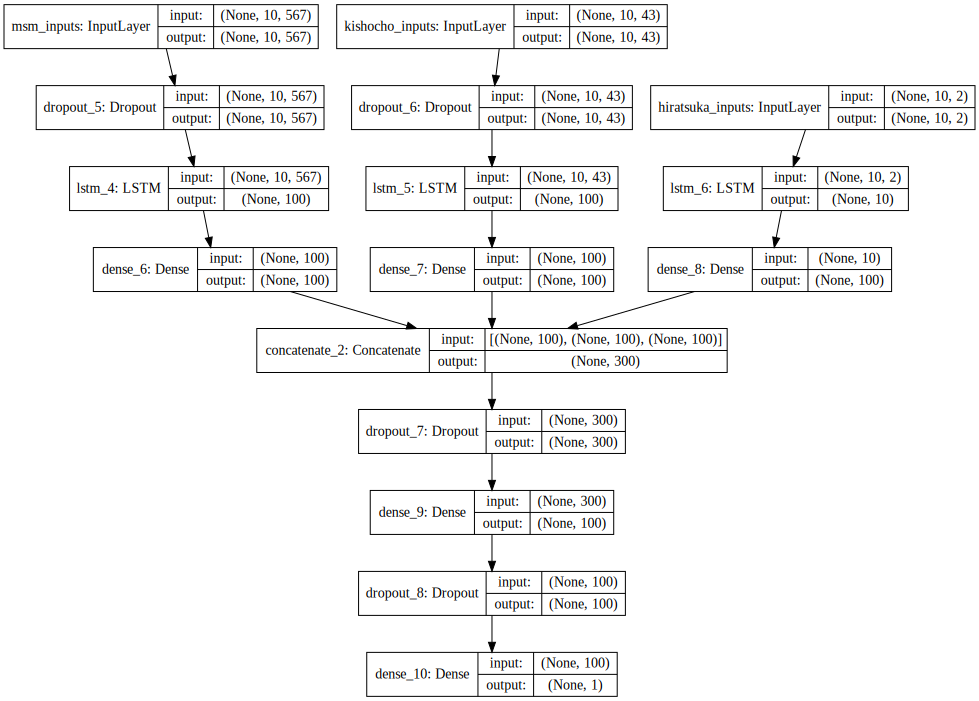

In [58]:
msm_inputs = Input(shape=train_rnn_msm.shape[1:2+1], name="msm_inputs")
kishocho_inputs = Input(shape=train_rnn_kishocho.shape[1:2+1], name="kishocho_inputs")
hiratsuka_inputs = Input(shape=train_rnn_hiratsuka.shape[1:2+1], name="hiratsuka_inputs")

msm = Dropout(0.2)(msm_inputs)
msm = LSTM(100)(msm)
msm = Dense(100, activation='relu')(msm)

kishocho = Dropout(0.2)(kishocho_inputs)
kishocho = LSTM(100)(kishocho)
kishocho = Dense(100, activation='relu')(kishocho)

hiratsuka = LSTM(10)(hiratsuka_inputs)
hiratsuka = Dense(100, activation='relu')(hiratsuka)

m = concatenate([msm, kishocho, hiratsuka], axis=1)
m = Dropout(0.5)(m)
m = Dense(100, activation='relu')(m)
m = Dropout(0.5)(m)

predictions = Dense(1)(m)

model = Model(inputs=[msm_inputs, kishocho_inputs, hiratsuka_inputs], outputs=predictions)

model.compile(optimizer='adam',
              loss='mse',
             )
SVG(model_to_dot(model, show_shapes = True).create(prog='dot', format='svg'))

In [59]:
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit([train_rnn_msm, train_rnn_kishocho, train_rnn_hiratsuka], train_label["label_UGRD"],
                    batch_size=1024,
                    epochs=1000,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[callback]
                   )

Train on 5211 samples, validate on 579 samples
Epoch 1/1000
5211/5211 [==============================] - 5s 894us/step - loss: 7.6091 - val_loss: 9.2219
Epoch 2/1000
5211/5211 [==============================] - 2s 350us/step - loss: 6.7759 - val_loss: 8.2277
Epoch 3/1000
5211/5211 [==============================] - 2s 349us/step - loss: 6.0902 - val_loss: 7.4071
Epoch 4/1000
5211/5211 [==============================] - 2s 350us/step - loss: 5.3713 - val_loss: 6.9911
Epoch 5/1000
5211/5211 [==============================] - 2s 347us/step - loss: 4.8507 - val_loss: 6.5377
Epoch 6/1000
5211/5211 [==============================] - 2s 345us/step - loss: 4.2606 - val_loss: 5.8742
Epoch 7/1000
5211/5211 [==============================] - 2s 355us/step - loss: 3.9685 - val_loss: 5.5134
Epoch 8/1000
5211/5211 [==============================] - 2s 348us/step - loss: 3.6693 - val_loss: 5.1529
Epoch 9/1000
5211/5211 [==============================] - 2s 350us/step - loss: 3.3926 - val_loss: 4.9786

1.63224566448
1.48814762809


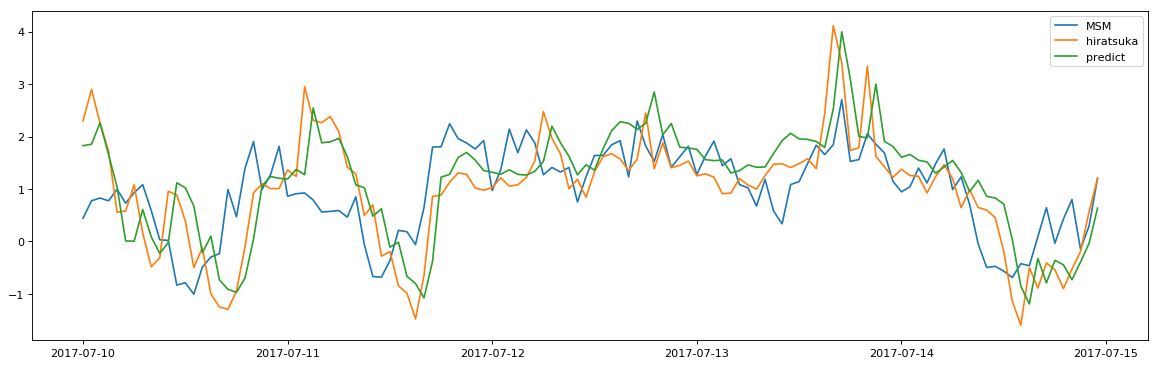

In [64]:
start = datetime(2017,7,10,0,0,0)
end = start + timedelta(days=5)
data_1 = test_data[["time", "msm_UGRD_35.30_139.3750_0"]]
data_2 = test_data[["time", "measured_UGRD_0"]]
data_3 = pd.DataFrame()
data_3["time"] =  test_data["time"] + timedelta(hours=predict_hour)
data_3["predict"] = model.predict([test_rnn_msm, test_rnn_kishocho, test_rnn_hiratsuka])

print(mean_squared_error(test_rnn_hiratsuka[:,-1,0], test_label["label_UGRD"]))
print(mean_squared_error(model.predict([test_rnn_msm, test_rnn_kishocho, test_rnn_hiratsuka]), test_label["label_UGRD"]))
plot_wind([data_1, data_2, data_3], ["msm_UGRD_35.30_139.3750_0", "measured_UGRD_0", "predict"], ["MSM", "hiratsuka", "predict"], start=start, end=end)